# Обучение и тест модели MLPModel
1. Подготовка данных ф-ия MLPDataset из dataset.py
2. Определение функции потерь и оптимизатора (MSE - среднеквадратичная ошибка,SGD - стохастический градиентный спуск)
3. Обучение модели
4. Обучение и тестирование на Кросс-Валидации, тк у нас очень маленькая выборка


In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
from sklearn.model_selection import KFold
from torchinfo import summary



from linRegres import MLPModel,LinearRegressionModel
from dataset import DatasetGenerator


In [3]:
def train_model(model_q, criterion_q, optimizer_q, train_loader_q, epochs_q):
    """
    Обучает модель с помощью данных из train_loader.

    Параметры:
    - model_q (torch.nn.Module): Обучаемая модель.
    - criterion_q (torch.nn): Функция потерь.
    - optimizer_q (torch.optim): Оптимизатор для обновления весов.
    - train_loader_q (DataLoader): DataLoader для итерации по обучающим данным.
    - epochs_q (int): Количество эпох для обучения.

    Возвращает:
    - train_losses (list): Список, содержащий среднюю потерю за каждую эпоху.
    """
    model_q.train()  # Перевод модели в режим обучения
    train_losses = []
    for epoch in range(epochs_q):
        epoch_loss = 0.0
        for inputs, labels in train_loader_q:
            optimizer_q.zero_grad()
            outputs = model_q(inputs)
            loss = criterion_q(outputs, labels)
            loss.backward()
            optimizer_q.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(train_loader_q.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    return train_losses

def test_model(model, criterion, test_loader):
    """
    Тестирует модель, используя данные из test_loader и вычисляет среднюю потерю.

    Параметры:
    - model (torch.nn.Module): Модель для тестирования.
    - criterion (torch.nn): Функция потерь.
    - test_loader (DataLoader): DataLoader для итерации по тестовым данным.

    Выводит:
    - Среднюю потерю на тестовом наборе.
    """
    model.eval()  # Переключаем модель в режим оценки
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    print(f'Средняя потеря на тестовом наборе: {avg_loss}')

def reset_weights(m):
    """
    Применяет реинициализацию весов к слоям модели.

    Параметры:
    - m (torch.nn.Module): Слой модели для реинициализации весов.

    Действие:
    - Инициализирует веса слоев Linear с использованием метода Kaiming и устанавливает небольшие начальные значения для bias.
    """
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
            

# Визуализация входных данных датасета
def plot_data(train_loader, label = 'None'):
    """
    Визуализирует входные данные из DataLoader.

    Параметры:
    - train_loader (DataLoader): DataLoader, содержащий тренировочный датасет.
    """
    plt.figure(figsize=(10, 5))
    plt.title(label)
    plt.xlabel('Вход X')
    plt.ylabel('Выход Y')
    for inputs, labels in train_loader:
        plt.scatter(inputs.numpy(), labels.numpy(), color='blue', alpha=0.5)
    plt.show()

# Построение результатов линейной регрессии в виде прямой линии
def plot_regression_line(model, test_loader):
    """
    Строит график входных данных и линейную регрессию, выполненную моделью.

    Параметры:
    - model (torch.nn.Module): Обученная модель.
    - test_loader (DataLoader): DataLoader, содержащий тестовый датасет.
    """
    model.eval()
    plt.figure(figsize=(10, 5))
    plt.title('Линейная регрессия')
    plt.xlabel('Вход X')
    plt.ylabel('Выход Y')

    inputs_all = torch.tensor([])
    labels_all = torch.tensor([])
    predictions_all = torch.tensor([])

    with torch.no_grad():
        for inputs, labels in test_loader:
            predictions = model(inputs)
            inputs_all = torch.cat((inputs_all, inputs), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    # Сортировка данных для корректного отображения линии регрессии
    sorted_indices = torch.argsort(inputs_all[:, 0])
    inputs_all = inputs_all[sorted_indices]
    labels_all = labels_all[sorted_indices]
    predictions_all = predictions_all[sorted_indices]

    # Отображение истинных данных и линии регрессии
    plt.scatter(inputs_all.numpy(), labels_all.numpy(), color='blue', alpha=0.5, label='Истинные значения')
    plt.plot(inputs_all.numpy(), predictions_all.numpy(), color='red', label='Линия регрессии')
    plt.legend()
    plt.show()


def plot_fold_losses(fold_losses):
    """
    Визуализирует потери на каждом фолде в процессе обучения.

    Параметры:
    - fold_losses (list of lists): Список списков потерь, где каждый внутренний список содержит историю потерь для одного фолда.
    """
    plt.figure(figsize=(10, 5))
    plt.title('Лосс функция по фолдам')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    for i, fold_loss in enumerate(fold_losses):
        plt.plot(fold_loss, label=f'Фолд {i+1}')
    plt.legend()
    plt.show()
      


In [4]:
#Импорт моделией
'''
---
Многослойный прецептрон, определение не линейной зависимости
2 слоя и ReLu
---
MLPModel(input_size=1, hidden_neurons=10, output_size=1)
---
Нейросеть из одного слоя
без регуляризации
определяет только напрямую линейную зависимость(линия)
---
LinearRegressionModel(input_size=1, output_size=1)
'''

model = LinearRegressionModel( input_size=1, output_size=1)
# Если есть доступ к GPU, лучше использовать его для ускорения вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LinearRegressionModel(
  (fc): Linear(in_features=1, out_features=1, bias=True)
)

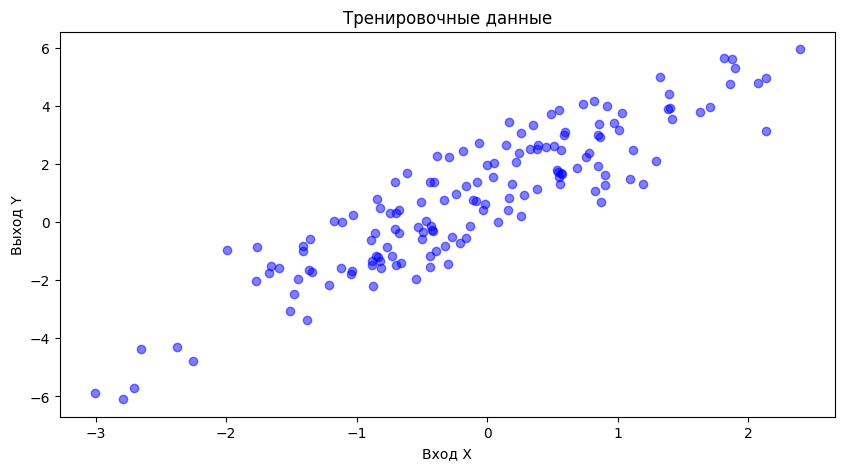

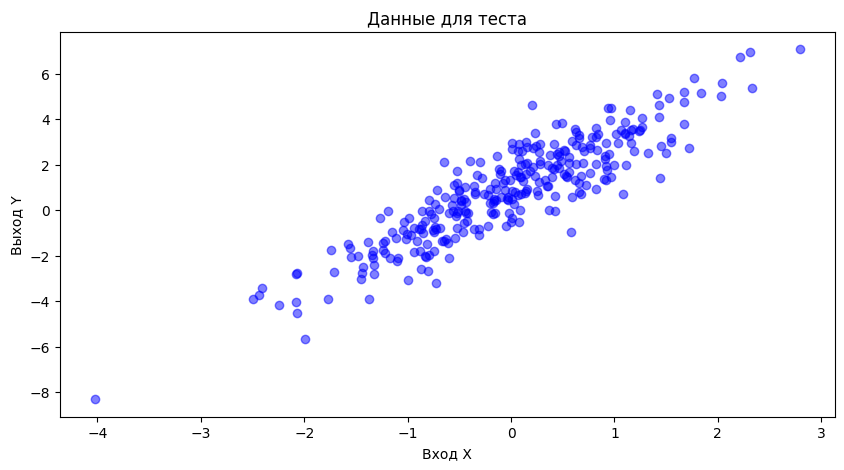

In [5]:
#Импорт Датасетов

#Линейное распределение
linnearEqualDataset = DatasetGenerator(num_samples= 100, num_outliers=0, outlier_mag=0, distribution= 'uniform', start = 0, end = 2)
#Нормальное распределение
normalEqualDataset = DatasetGenerator(num_samples= 150, num_outliers=0, outlier_mag=2, distribution= 'normal', mean = 0, std = 1)
#Лог-нормальное распределение
logNormalEqualDataset = DatasetGenerator(num_samples= 250, num_outliers=5, outlier_mag=2, distribution= 'log_normal', mean = 0, std = 1)
#Экспоненциальное распределение
expEqualDataset = DatasetGenerator(num_samples= 250, num_outliers=5, outlier_mag=2, distribution= 'exponential', rate = 1)
#Гамма-распределение
gammaEqualDataset = DatasetGenerator(num_samples= 250, num_outliers=5, outlier_mag=2, distribution= 'gamma', shape = 2, scale = 1)



'''
Задается X
'''
#Генерация Y под выбранный X(задается переменная XdistributionExample шаблоном одного из класса выше)
XdistributionExample = normalEqualDataset


#Линейная регрессия
linnearRegressionData = XdistributionExample.linear_regression(a=2.0, b=1.0, noise_variance=1)
#Полиномиальная регрессия
polinomRegressionData = XdistributionExample.polynomial_regression(coefficients=[1, 0, 2], noise_variance=1.0)
#Логистическая регрессия
logisticRegressionData = XdistributionExample.logistic_regression(w=1.0, b=1.0, noise_variance=0.5)



'''
Задается X_Y
'''
#Выгрузка пары X_Y отностиельно модели формирования Y(задается переменная datasetExample шаблоном одной из функций выше)
datasetExample = linnearRegressionData

#Финальнео формирование PyTorch.TensorDataset и PyTorch.DataLoader
dataset = TensorDataset(datasetExample[0], datasetExample[1])  # Создание датасета
train_loader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)  # Создание DataLoader'а
plot_data(train_loader, label = 'Тренировочные данные')





'''
Задается X_Y для теста после обучения
'''
XdistributionExample_test = DatasetGenerator(num_samples= 300, num_outliers=0, outlier_mag=2, distribution= 'normal', mean = 0, std = 1)
datasetExample_test = XdistributionExample_test.linear_regression(a=2.0, b=1.0, noise_variance=1)
dataset_test = TensorDataset(datasetExample_test[0], datasetExample_test[1])  # Создание датасета
test_loader = DataLoader(dataset=dataset_test, batch_size=5, shuffle=True)  # Создание DataLoader'а
plot_data(test_loader, label = 'Данные для теста')

In [6]:
#MSE
criterion = nn.MSELoss()  
# Стохастический градиентный спуск
optimizer = optim.SGD(model.parameters(), lr=0.1)  #Епсилон = 0.1

In [7]:
# Настройка KFold
# Параметры
k_folds = 5  # Количество фолдов для кросс-валидации
epochs = 200  # Количество эпох обучения
kfold = KFold(n_splits=k_folds, shuffle=True)

fold_losses = []  # Список для хранения истории потерь для каждого фолда

# Запуск к-фолд кросс-валидации
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    
    # Сэмплеры для обучающего и тестового набора
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)
    
    # DataLoader'ы для текущего разбиения
    train_loader_in = DataLoader(dataset, batch_size=10, sampler=train_subsampler)
    test_loader_in = DataLoader(dataset, batch_size=10, sampler=test_subsampler)
    
    # Сброс параметров модели для нового фолда
    model.apply(reset_weights)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  # Создание нового оптимизатора может быть также полезным для сброса моментов
    
    # Обучение модели и сохранение истории потерь
    fold_loss = train_model(model, criterion, optimizer, train_loader_in, epochs)
    fold_losses.append(fold_loss)
    
    # Тестирование модели
    model.eval()  # Перевод модели в режим оценки
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader_in:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    print(f'Test Loss for fold {fold}: {total_loss / len(test_loader_in)}\n')



FOLD 1
--------------------------------
Epoch 1, Loss: 2.6240280866622925
Epoch 2, Loss: 0.8280385533968607
Epoch 3, Loss: 0.8256306489308675
Epoch 4, Loss: 0.8350469807783762
Epoch 5, Loss: 0.8103308041890462
Epoch 6, Loss: 0.8271772583325704
Epoch 7, Loss: 0.8130190889040629
Epoch 8, Loss: 0.8261964678764343
Epoch 9, Loss: 0.828938098748525
Epoch 10, Loss: 0.8220187187194824
Epoch 11, Loss: 0.8231945057710012
Epoch 12, Loss: 0.8041201174259186
Epoch 13, Loss: 0.8110864937305451
Epoch 14, Loss: 0.8154148499170939
Epoch 15, Loss: 0.8426153937975566
Epoch 16, Loss: 0.8325520356496176
Epoch 17, Loss: 0.8336247364679973
Epoch 18, Loss: 0.8225116968154907
Epoch 19, Loss: 0.8070451339085897
Epoch 20, Loss: 0.8351484537124634
Epoch 21, Loss: 0.8170427600542705
Epoch 22, Loss: 0.7952766577402751
Epoch 23, Loss: 0.8327251235644023
Epoch 24, Loss: 0.8059174418449402
Epoch 25, Loss: 0.8350244998931885
Epoch 26, Loss: 0.8191643675168355
Epoch 27, Loss: 0.8342371503512065
Epoch 28, Loss: 0.8258410

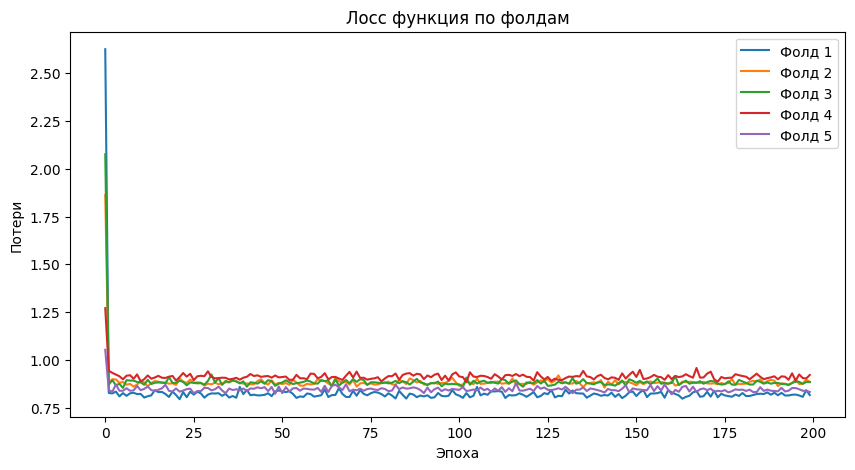

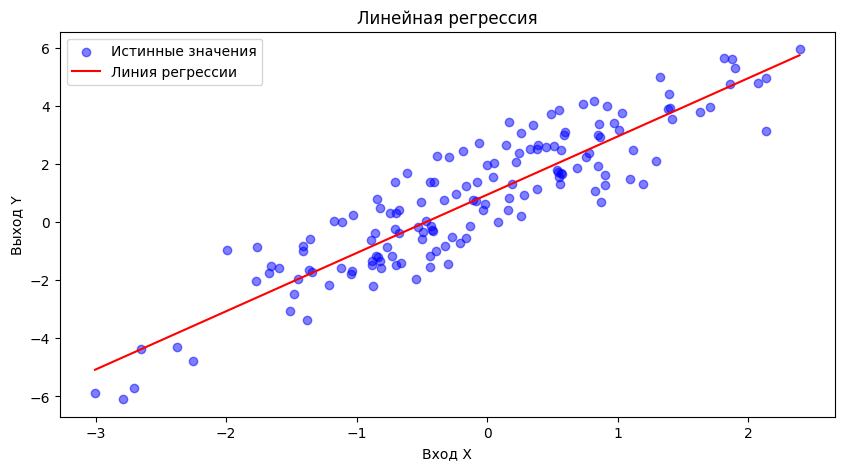

In [8]:
# Визуализация потерь для каждого фолда
plot_fold_losses(fold_losses)

# Визуализация результатов
plot_regression_line(model, train_loader)

In [10]:
# Вывод сводной информации о модели
summary(model, input_size=(1,))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegressionModel                    [1]                       --
├─Linear: 1-1                            [1]                       2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

Средняя потеря на тестовом наборе: 0.9606696163614591


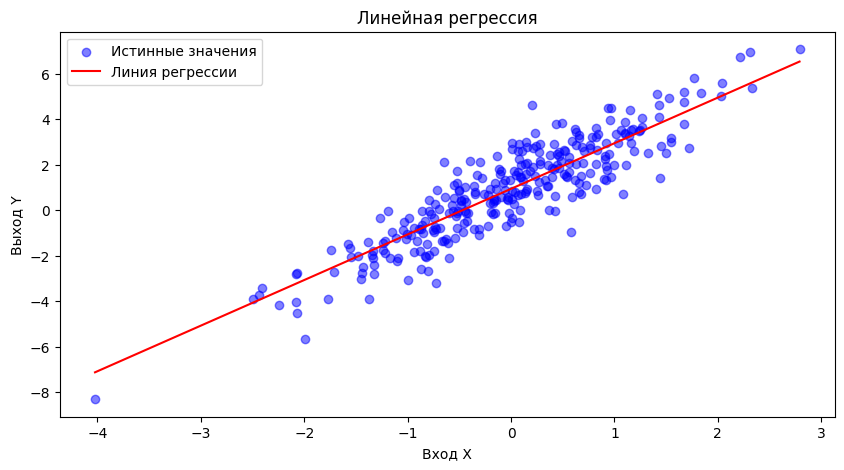

In [11]:
# Проверка лосса модели на заранее инициализированной тестовой выборке
test_model(model, criterion, test_loader)

# Визуализация результатов
plot_regression_line(model, test_loader)

In [28]:
example_input = torch.randn(100, 1)
traced_model = torch.jit.trace(model, example_input)

###ТРЕЙСИНГ ИЛИ СКРИПТИНГ?????????????????????????????????????/
summary(traced_model, input_size=(1,))

#mlmodel = ct.convert(traced_model, inputs=[ct.TensorType(shape=example_input.shape)])
#mlmodel.save("MyModel.mlmodel")

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegressionModel                    --                        --
├─Linear: 1-1                            --                        2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [11]:
# Сохранение параметров модели
#torch.save(model.state_dict(), 'model_params.pth')


'''
# Загрузка параметров модели
model = MLPModel()  
model.load_state_dict(torch.load('mlp_model_params.pth'))
model.eval()  # Перевод модели в режим оценки 
'''

"\n# Загрузка параметров модели\nmodel = MLPModel()  \nmodel.load_state_dict(torch.load('mlp_model_params.pth'))\nmodel.eval()  # Перевод модели в режим оценки \n"

In [ ]:
'''
==================================

Сохранение всей модели

Этот способ включает сохранение всей структуры модели вместе с её параметрами. 
Это удобно, когда вам нужно загрузить модель в другой среде или на другом устройстве 
без необходимости заново определять архитектуру модели.

torch.save(model, 'model.pth')
---
model = torch.load('model.pth')

==================================

Сохранение только параметров (весов) модели

Это предпочтительный способ сохранения моделей PyTorch, так как он требует, 
чтобы архитектура модели была определена заново в коде перед загрузкой параметров.

torch.save(model.state_dict(), 'model_weights.pth')
---
model = MyModel()  # Переопределение модели
model.load_state_dict(torch.load('model_weights.pth'))

==================================

Сохранение модели в формате TorchScript

TorchScript предоставляет способ сохранения моделей, который делает их независимыми от исходного кода Python, 
позволяя запускать модели на других платформах с использованием C++ API.

scripted_model = torch.jit.script(model)  # Или использование torch.jit.trace
torch.jit.save(scripted_model, 'model_scripted.pt')
---
loaded_model = torch.jit.load('model_scripted.pt')

==================================
'''


In [30]:
pathToSave = r''

#Сохранение всей модели
torch.save(model, 'full_model.pth')


#Сохранение только параметров (весов) модели
torch.save(model.state_dict(), 'model_weights.pth')


In [33]:
#Сохранение модели в формате TorchScript
#scripted_model = torch.jit.script(model)
#torch.jit.save(scripted_model, 'model_scripted.pt')


#Сохранение модели в формате TorchTrase
input_trase_example = torch.randn(10, 1)
traced_model = torch.jit.trace(model, input_trase_example)
torch.jit.save(traced_model, 'model_traced.pt')